# IMPORT MODULES

In [1]:
!pip install transformers


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# Load your sentiment dataset (e.g., from a CSV file)
data = pd.read_csv('/content/Tweets.csv')

 # DATA PREPROCESSING

In [4]:
texts = [[word.lower() for word in text.split()] for text in data]

In [5]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [8]:
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


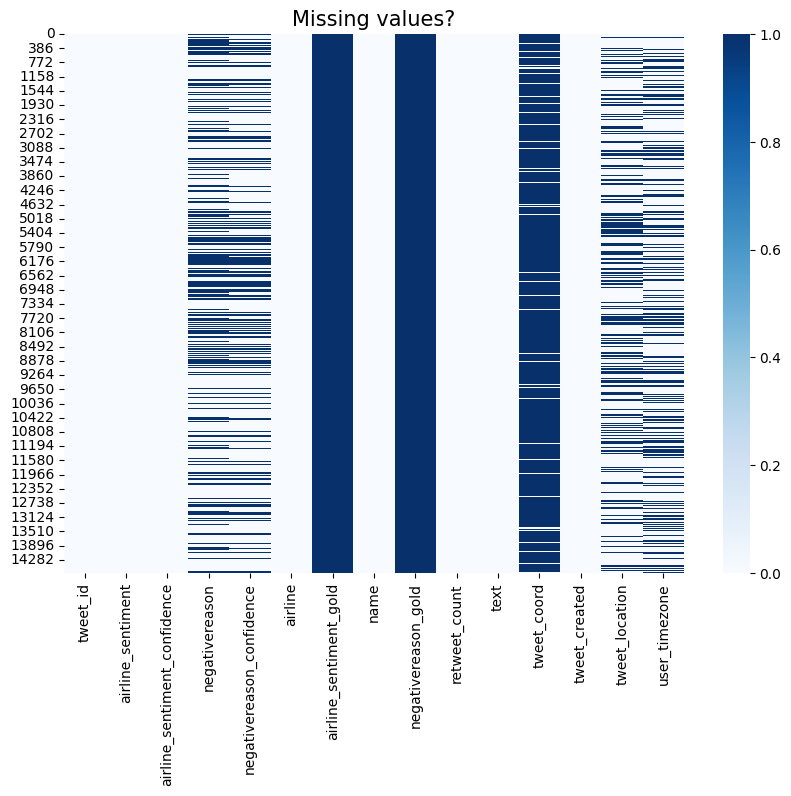

In [9]:
#Visualization of missing value using heatmap
plt.figure(figsize=(10,7))
sns.heatmap(data.isnull(), cmap = "Blues")
plt.title("Missing values?", fontsize = 15)
plt.show()

In [10]:
print("Percentage null or na values in data")
((data.isnull() | data.isna()).sum() * 100 / data.index.size).round(2)

Percentage null or na values in data


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

In [11]:
data.drop(["tweet_coord", "airline_sentiment_gold", "negativereason_gold"], axis=1, inplace=True)

In [12]:
freq = data.groupby("negativereason").size()

In [13]:
data.duplicated().sum()

39

In [14]:
# Dropping duplicates
data.drop_duplicates(inplace = True)

In [15]:
data.duplicated().sum()

0

In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14601.0,5.692156e+17,7.782706e+14,5.675883e+17,5.685581e+17,5.694720e+17,5.698884e+17,5.703106e+17
airline_sentiment_confidence,14601.0,8.999022e-01,1.629654e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10501.0,6.375749e-01,3.303735e-01,0.000000e+00,3.605000e-01,6.705000e-01,1.000000e+00,1.000000e+00
retweet_count,14601.0,8.280255e-02,7.467231e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


# EXPLORATORY DATA ANALYSIS

In [17]:
data.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
name                             7701
retweet_count                      18
text                            14427
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

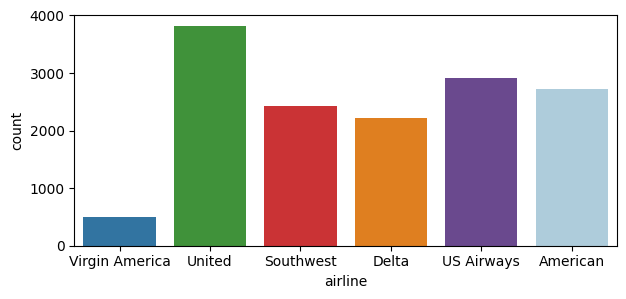

In [18]:
# Checking the distribution of airlines
plt.figure(figsize=(7,3))
sns.countplot(data=data,x='airline', palette=['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#a6cee3'])
plt.show()

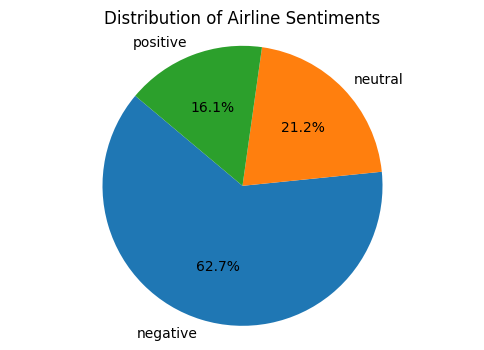

In [19]:
sentiment_counts = data['airline_sentiment'].value_counts()
plt.figure(figsize=(6, 4))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Airline Sentiments')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


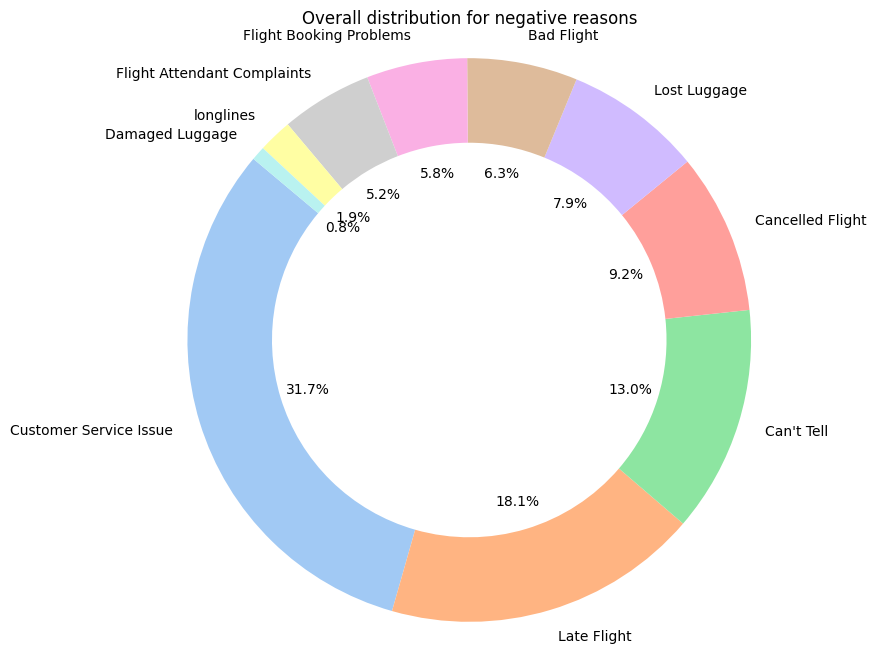

In [20]:
# Calculate the value counts for each negative reason
value_counts = data['negativereason'].value_counts()

# Create a donut-like pie chart using matplotlib and seaborn
plt.figure(figsize=(8, 8))
labels = value_counts.index
values = value_counts.values
colors = sns.color_palette('pastel')[0:len(labels)]  # Use pastel colors for the chart
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Overall distribution for negative reasons')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is drawn as a circle.
plt.show()

In [21]:
# Select only the necessary columns for sentiment analysis
data = data[['airline_sentiment', 'text']].copy()

# TRAINING THE MODEL

In [ ]:
# Data Preprocessing
X = data["text"]
y = data["airline_sentiment"]

TRAINING THE MODEL

In [ ]:
# Bag of Words
vectorizer = CountVectorizer(max_features=5000)
X_bow = vectorizer.fit_transform(X)


In [ ]:
# LSTM Model
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=200)

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Transformer Model (BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_bert = tokenizer(X.tolist(), padding=True, truncation=True, return_tensors='tf')

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
X_bert = bert_model(X_bert)


In [ ]:
# Train Bag of Words model
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression(max_iter=1000)
bow_model.fit(X_train, y_train)
y_pred = bow_model.predict(X_test)
bow_accuracy = accuracy_score(y_test, y_pred)

In [ ]:
# Train LSTM model
lstm_model.fit(X_lstm, y, epochs=5, batch_size=32)
lstm_accuracy = lstm_model.evaluate(X_lstm, y)[1]


In [ ]:
# Train Transformer model
inputs = tf.keras.layers.Input(shape=(X_bert.last_hidden_state.shape[1], X_bert.last_hidden_state.shape[2]), dtype=tf.float32)
x = tf.keras.layers.LSTM(64)(inputs)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
transformer_lstm_model = tf.keras.Model(inputs=inputs, outputs=x)
transformer_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

transformer_lstm_model.fit(X_bert.last_hidden_state, y, epochs=5, batch_size=32)
transformer_accuracy = transformer_lstm_model.evaluate(X_bert.last_hidden_state, y)[1]


In [ ]:
# Evaluate models
print(f"Bag of Words Accuracy: {bow_accuracy}")
print(f"LSTM Accuracy: {lstm_accuracy}")
print(f"Transformer Accuracy: {transformer_accuracy}")
